# Projektarbeit

Notiz:
Der Code im Jupyter-Notebook wurde mit VSC und der Erweiterung Autopep8 formatiert.

In [1]:
import pandas as pd
import numpy as np
from sklearn import neural_network
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
from os import path
import seaborn as sns

In [2]:
pkl = "data/accesspoints.pkl"
if not path.exists(pkl):
    csv_name = "data/creditcard_2023.csv"
    print(pkl, "does not exist, reading", csv_name, "instead")
    df = pd.read_csv(csv_name)
    df.to_feather(pkl)
else:
    print("reading", pkl)
    df = pd.read_pickle(pkl)
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

reading data/accesspoints.pkl


In [3]:
# The format we save fingerprints in is not the format we need for our classifiers/regressors.
INDEX = 0
INDEX_FINGERPRINT = 0
INDEX_XPOS = 1
INDEX_YPOS = 2
INDEX_BSSID = 4
INDEX_SIGNAL = 5
INDEX_LOCATION = 7


def convert_df(pickle_path: str, fingerprint_count: int):
    """ knn_func description placeholder"""
    HIGHEST_AMOUNT_OF_ACCESSPOINTS_IN_A_FINGERPRINT = 100  # TODO
    HIGH = HIGHEST_AMOUNT_OF_ACCESSPOINTS_IN_A_FINGERPRINT
    UNIQUE_APS_TOTAL = 120  # TODO remove magic numbers

    df = pd.read_pickle(pickle_path)
    df_len = len(df)
    list_of_dicts = []  # TODO make sure this is filled at index 1 with fingerprint 1. It might be necessary to sort the fingerprints in the dataframe
    fingerprint_location_map = {}
    for i in range(fingerprint_count):
        list_of_dicts.append({})

    # filling the list of dicts and the fingerprint_location_map
    # key is fingerprint_id, value is xpos etc.
    for i in range(df_len):
        fingerprint_location_map[df.iloc[i, INDEX_FINGERPRINT]] = df.iloc[i,
                                                                          INDEX_XPOS], df.iloc[i, INDEX_YPOS], df.iloc[i, INDEX_LOCATION]
        index = df.iloc[i, INDEX_FINGERPRINT]
        keyname = df.iloc[i, INDEX_BSSID]
        value = df.iloc[i, INDEX_SIGNAL]
        list_of_dicts[index][keyname] = value
    # key is the fingerprint_number, value is how many APs are in BOTH the current_position_scan and the fingerprint scan
    # print("mylist=", mylist)
    """change the format of the df to use it with knn.
    format should be bssidd -> list[fingerprint_ID,signal_strength]
    format in df is currently: 
    fingerprint_ID, bssid, signalstrength
    ...
    """
    print("type=", type((5, 6)))
    x_train = np.zeros((fingerprint_count, UNIQUE_APS_TOTAL))
    y_train = np.zeros(fingerprint_count)
    """ we need to map bssids to integers so we can use the integers as index for our ndarray
        algorithm: for every bssid, check if it's already in the map. if not, add it to the map.
    
    """
    bssid_map = {}
    """bssid_map key: bssid, value: index of that bssid
    """
    for i in range(len(df)):
        bssid = df.iloc[i, INDEX_BSSID]
        if bssid not in bssid_map:
            # TODO lookup table should be faster than a map? idk
            bssid_map[bssid] = len(bssid_map)
        signal = df.iloc[i, INDEX_SIGNAL]
        fingerprint_id = df.iloc[i, INDEX_FINGERPRINT]
        location = df.iloc[i, INDEX_LOCATION]
        x_train[fingerprint_id, bssid_map[bssid]] = signal
        y_train[fingerprint_id] = fingerprint_id
    return x_train, y_train


config_df = pd.read_csv("data/config.csv")
# fingerprint_count formerly fingerprint_number is the count of
amount_of_fingerprints = config_df.loc[:, 'fingerprint_id'][0]
# fingerprints. fingerprint_id should be the individual id of a fingerprint
x_ges, y_ges = convert_df("data/accesspoints.pkl", amount_of_fingerprints)
print(x_ges.shape, y_ges.shape)
data = np.append(x_ges, y_ges.reshape(43, 1), axis=1)
df = pd.DataFrame(data)
print(df.head())

type= <class 'tuple'>
(43, 120) (43,)
    0     1     2     3     4     5     6     7     8     9     10    11    
0  50.0  31.0  91.0  31.0  83.0  43.0  50.0  40.0  53.0  40.0  40.0  31.0  \
1  53.0  31.0  78.0  31.0  85.0  43.0  50.0  43.0  53.0  40.0  40.0  31.0   
2  46.0  31.0  91.0  31.0  85.0  81.0  50.0  81.0  46.0  40.0  40.0  31.0   
3  57.0  35.0  92.0  43.0  82.0  62.0  50.0  60.0  57.0  40.0  40.0  38.0   
4  53.0  35.0  92.0  43.0  87.0  80.0  50.0  81.0  57.0  40.0  40.0  38.0   

    12    13    14    15    16    17    18    19    20    21    22    23    
0  81.0  46.0  31.0  72.0  31.0  31.0  70.0  86.0   0.0   0.0   0.0   0.0  \
1  81.0  46.0  31.0  57.0  31.0  31.0  81.0  86.0  40.0  46.0  31.0  31.0   
2  81.0  81.0  31.0  57.0  31.0  31.0  40.0  91.0  40.0  81.0  31.0  31.0   
3  81.0  67.0  60.0  40.0  31.0  31.0  84.0  85.0  40.0  81.0  35.0  31.0   
4  81.0  80.0  35.0  40.0  31.0  31.0  83.0  87.0  40.0  80.0  35.0  31.0   

    24    25    26    27    28    29

In [4]:
# Zeilen, Spalten des Dataframes anzeigen lassen
print(df.shape)

# Spalten mit fehlenden Werten
missing_values = df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]
if columns_with_missing_values.empty:
    print("Es gibt keine Spalten mit fehlenden Werten.")
else:
    print("Spalten mit fehlenden Werten:")
    print(columns_with_missing_values)

# Daten auf nur numerische Werte prüfen
data_types = df.dtypes
are_numeric = all(data_types.apply(lambda x: pd.api.types.is_numeric_dtype(x)))
if are_numeric:
    print("Alle Spalten enthalten numerische Werte.")
else:
    print("Es gibt nicht-numerische Werte in mindestens einer Spalte.")

# Ersten 5 Zeilen des Dataframes anzeigen lassen
df.head(5)

(43, 121)
Es gibt keine Spalten mit fehlenden Werten.
Alle Spalten enthalten numerische Werte.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120
0,50.0,31.0,91.0,31.0,83.0,43.0,50.0,40.0,53.0,40.0,40.0,31.0,81.0,46.0,31.0,72.0,31.0,31.0,70.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,53.0,31.0,78.0,31.0,85.0,43.0,50.0,43.0,53.0,40.0,40.0,31.0,81.0,46.0,31.0,57.0,31.0,31.0,81.0,86.0,40.0,46.0,31.0,31.0,31.0,31.0,31.0,31.0,38.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,46.0,31.0,91.0,31.0,85.0,81.0,50.0,81.0,46.0,40.0,40.0,31.0,81.0,81.0,31.0,57.0,31.0,31.0,40.0,91.0,40.0,81.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,40.0,31.0,31.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,57.0,35.0,92.0,43.0,82.0,62.0,50.0,60.0,57.0,40.0,40.0,38.0,81.0,67.0,60.0,40.0,31.0,31.0,84.0,85.0,40.0,81.0,35.0,31.0,31.0,38.0,31.0,31.0,40.0,40.0,31.0,31.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,53.0,35.0,92.0,43.0,87.0,80.0,50.0,81.0,57.0,40.0,40.0,38.0,81.0,80.0,35.0,40.0,31.0,31.0,83.0,87.0,40.0,80.0,35.0,31.0,31.0,31.0,31.0,31.0,40.0,40.0,31.0,31.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


##### Statistische Merkmale
Die Betrachtung der Spalte 'id' ist für diesen Abschnitt irrelevant, da diese einfach nur pro Zeile um 1 inkrementiert wird.  

In den Spalten V1-V28 kann man erkennen, dass die Standardabweichung jeweils bei etwa 1.0 liegt und der Mittelwert bei knapp 0.0.  
Dies deutet darauf hin, dass die Daten bereits standardisiert wurden und wir dies nicht mehr unternehmen müssen.  
Lediglich die Spalte 'Amount' wurde nicht standardisiert.  
Die Geldbeträge der Transaktionen liegen zwischen 50 und 24.000€, wobei der Mittelwert bei 12.000€ liegt.

In [5]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.00000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.000000
mean,54.511628,49.534884,50.348837,34.465116,51.930233,56.116279,66.046512,57.116279,54.906977,44.093023,43.813953,49.023256,40.581395,55.627907,26.813953,26.279070,49.976744,50.651163,66.279070,57.906977,30.697674,52.976744,48.255814,51.558140,36.744186,48.441860,52.325581,33.27907,55.860465,40.558140,30.767442,20.906977,21.046512,7.930233,38.930233,53.627907,35.209302,24.255814,41.720930,20.302326,32.488372,17.674419,11.162791,21.395349,21.395349,25.930233,10.093023,29.651163,23.744186,9.767442,27.465116,27.325581,10.186047,25.744186,21.790698,17.232558,10.186047,26.651163,8.651163,9.465116,29.116279,24.186047,24.395349,13.023256,13.023256,23.046512,22.325581,19.930233,22.767442,17.744186,23.465116,15.837209,24.069767,14.023256,13.348837,16.255814,14.395349,24.046512,12.093023,11.558140,10.232558,11.790698,14.534884,13.953488,8.372093,8.372093,19.116279,10.930233,10.232558,11.860465,8.767442,8.372093,7.441860,7.046512,7.627907,5.767442,5.046512,5.046512,5.046512,5.046512,5.046512,4.651163,4.720930,3.720930,4.883721,1.232558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.000000
std,16.997720,20.451276,25.431405,17.806297,21.463585,21.400055,16.221610,21.508812,16.528207,9.526439,9.037635,20.592981,33.484348,19.785785,19.248075,23.672694,21.034539,20.474006,19.067956,24.885274,17.098503,26.081820,21.051064,26.125432,13.730559,21.882046,24.043335,18.90871,19.836932,7.749969,15.679585,14.698257,14.805008,13.685925,22.450364,27.012363,21.947511,17.928553,27.801444,15.885805,25.929733,20.099421,18.154011,20.187384,20.187384,20.570894,14.698257,21.561522,25.813519,15.884759,19.567160,19.446778,14.845644,19.922580,15.833295,18.463396,14.845644,21.027062,14.069358,14.554248,23.959499,19.788472,21.829578,18.965493,18.965493,21.400883,26.622333,19.378922,23.284817,17.998800,25.636979,16.694639,29.157532,19.391319,19.890035,18.236662,16.501284,28.315361,18.588032,16.942905,17.659258,15.541891,19.090447,19.289713,16.465004,16.465004,28.138441,16.169335,17.659258,22.471762,17.418979,16.465004,15.749985,14.064399,15.297095,12.206238,11.579854,11.579854,11.579854,11.579854,11.579854,12.974120,13.603791,11.756104,18.043874,8.082424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.556539
min,40.000000,31.000000,0.000000,0.000000,31.000000,31.000000,40.000000,31.000000,40.000000,40.000000,40.000000,31.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,40.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

##### Korrelationsmatrix
Im Folgenden stellen wir die Korrelationsmatrix für unseren Datensatz dar, um die linearen Beziehungen der Spalten zu betrachten.  
Da die Korrelationsmatrix durch die vielen Spalten sehr unübersichtlich ist, beschränken wir uns in der zweiten Abbildung auf die starken Korrelationen.  
Es werden jeweils in roten Farben die positiven Korrelationen und in blauen Farben die negativen Korrelationen dargestellt. 

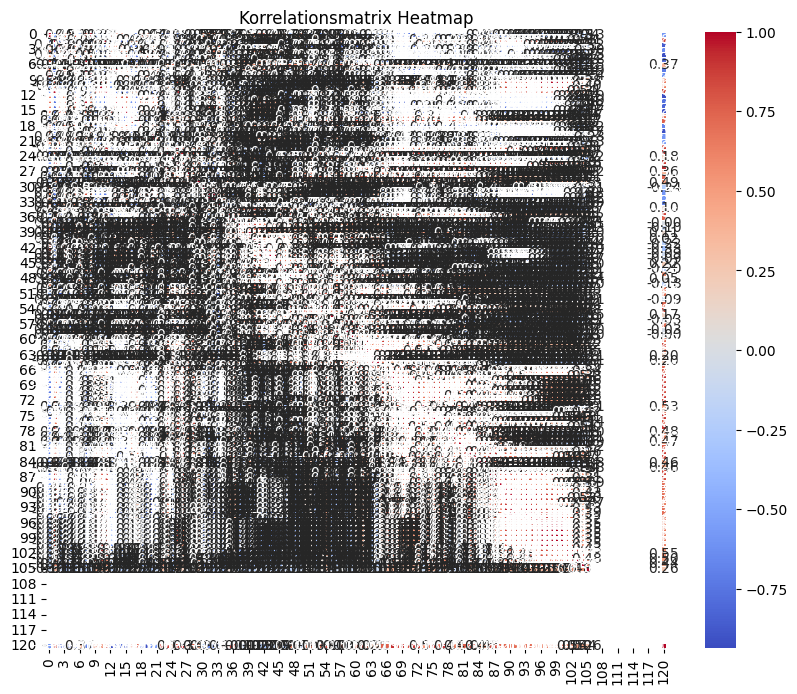

In [6]:
# Korrelationsmatrix
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsmatrix Heatmap')
plt.show()

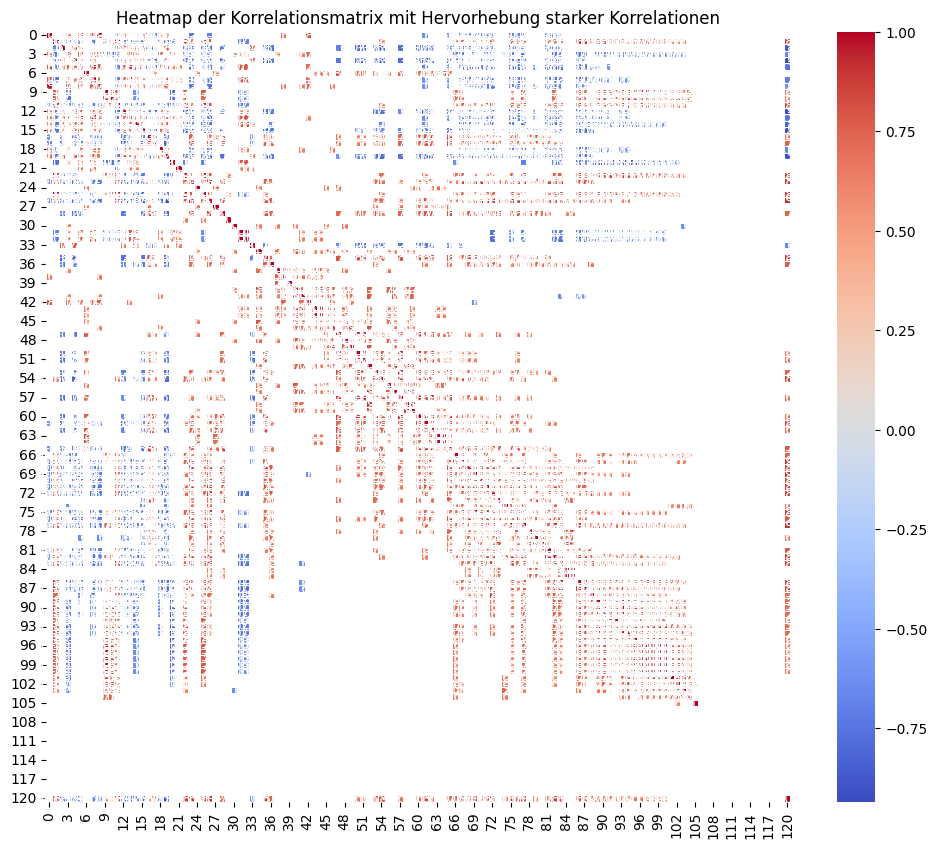

In [7]:
# Heatmap mit Hervorhebung starker Korrelationen
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix[(correlation_matrix > 0.6) | (correlation_matrix < -0.6)], annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap der Korrelationsmatrix mit Hervorhebung starker Korrelationen')
plt.show()

##### Scatterplots der wichtigsten Korrelationen

Nun schauen wir uns die Scatterplots der Spalten an, die hohe Korrelationen enthalten.  
Zuerst sehen wir, dass es einen Zusammenhang zwischen der id und dem Label 'Class' gibt.  
Aus der Abbildung kann man entnehmen, dass in der zweiten Hälfte des Datensatzes, also die ID's von 250.000-500.000 deutlich mehr betrügerische Transaktionen halten, als die erste Hälfte.  
Daraus können wir schließen, dass die Spalte 'id' für die Modellbildung entfernt werden sollte, da man für zukünftige Datensätze nicht von einer ähnlichen Korrelation ausgehen kann.

Des Weiteren gibt es einen Zusammenhang zwischen den Spalten 'V14' und 'Class' sowie 'V12' und 'Class'.  
Man kann jeweils sehen, dass die betrügerischen Transaktionen in einem bestimmten Bereich der Features sind.  
Wir können also erwarten, dass diese zwei Features für unsere Modellbildung von großer Bedeutung sein werden.

Zuletzt sehen wir einen linearen Zusammenhang zwischen 'V17' und 'V16'.  
Zu Erkennen ist, dass mit einer Zunahme von 'V16' auch 'V17' leicht zunimmt.  
Da die Daten allerdings anonymisiert sind und wir keine näheren Informationen zu diesem Datensatz haben, können wir keine weiteren Schlüsse ziehen.

In [8]:
# # Scatterplots der folgenden Spalten:
# # id und Class
# # V14 und Class
# # V12 und Class
# # V17 und V16
# columns_to_plot = [('id', 'Class'), ('V14', 'Class'), ('V12', 'Class'), ('V17', 'V16')]


# # produce a legend with the unique colors from the scatter
# for column_x, column_y in columns_to_plot:
#     fig, ax = plt.subplots()
#     if column_x == "V17":
#         scatter = ax.scatter(df[column_x], df[column_y], alpha=0.3, c=df['Class'], edgecolors='none', marker=".")
#         legend1 = ax.legend(*scatter.legend_elements(),
#                             loc="best", title="Classes")
#         ax.add_artist(legend1)
#         plt.ylim(df[column_y].quantile(0)-0.5, df[column_y].quantile(0.9999))

#     else:
#         plt.scatter(df[column_x], df[column_y], alpha=0.1)
#         pass
#     plt.title(f'Scatterplot von {column_x} vs. {column_y}')
#     plt.xlabel(column_x)
#     plt.ylabel(column_y)
#     plt.show()

##### Ausreißer

Als nächstes stellen wir die Ausreißer mit Hilfe von Boxplots dar.  
In diesem Abschnitt verwenden wir den Interquantilsabstand (IQR), um die Anzahl an Ausreißer auszugeben.  
Der IQR ist die Differenz zwischen dem dritten Quantil (Q3) und dem ersten Quantil (Q1) einer Verteilung.  
Die typische Regel ist, dass Werte außerhalb des Bereichs $[Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]$ als Ausreißer betrachtet werden.

In [9]:
# # Ausreißer herausfiltern
# column_names = ['V1', 'V3', 'V11', 'V13', 'V24', 'Amount']

# for column_name in column_names:
#     sns.boxplot(x=df[column_name])
#     plt.title(f'Boxplot der Spalte {column_name}')
#     plt.show()

#     # IQR berechnen
#     Q1 = df[column_name].quantile(0.25)
#     Q3 = df[column_name].quantile(0.75)
#     IQR = Q3 - Q1

#     # Ausreißer filtern
#     outliers = df.loc[(df[column_name] < Q1 - 1.5 * IQR) | (df[column_name] > Q3 + 1.5 * IQR), ['id']]
#     print(f"Ausreißer in Spalte '{column_name}':")
#     print(len(outliers))

##### Principal Component Analysis (PCA)
Nachfolgend führen wir eine Principal Component Analysis (PCA) durch.  
Die Ausgabe zeigt die kumulative Summe der erklärten Varianzanteile für jede Hauptkomponente.  
Die Tabelle zeigt den Beitrag jeder einzelnen Spalte zu dieser kumulativen Summe.

Die ersten Hauptkomponenten tragen einen erheblichen Teil der ursprünglichen Information in den Daten bei.  
In diesem Datensatz erklären die ersten 10 Hauptkomponenten etwa 70% der Gesamtvarianz.


In [10]:
# # PCA
# from sklearn.decomposition import PCA
# features = df.iloc[:, :-1]

# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(features)

# pca = PCA()
# pca_result = pca.fit_transform(scaled_data)

# explained_variance_ratio = pca.explained_variance_ratio_

# column_names = features.columns
# print(column_names)
# column_names2=[]
# for i in column_names:
#     column_names2.append("Spalte"+str(i))
# print("len",len(explained_variance_ratio),len(column_names2))

# variance_df = pd.DataFrame({'Explained Variance Ratio': explained_variance_ratio, 'Column Name': column_names2})

# variance_df_sorted = variance_df.sort_values(by='Explained Variance Ratio', ascending=False)

# print(variance_df_sorted)

# cumulative_explained_variance = explained_variance_ratio.cumsum()

# plt.plot(cumulative_explained_variance)
# plt.xlabel('Anzahl der Hauptkomponenten')
# plt.ylabel('Kumulative erklärte Varianz')
# plt.show()

Nun wird eine Schranke festgelegt, wodurch wir die Hauptkomponenten entnehmen, die 95% der Varianz ausmachen.  
Dadurch können wir feststellen, dass die Features V23-V28 sowie Amount nur 5% der Varianz ausmachen.  
Somit könnten wir diese für unsere Modellbildung entfernen, um das Modell zu performieren.

In [11]:
# # Finde die Anzahl der Hauptkomponenten, die 95% der Varianz erklären
# num_components_95_variance = np.argmax(cumulative_explained_variance >= 0.95) + 1

# # Extrahiere die relevanten Hauptkomponenten
# selected_pca_components = pca_result[:, :num_components_95_variance]

# # Erstelle ein DataFrame für die ausgewählten Hauptkomponenten
# selected_pca_df = pd.DataFrame(selected_pca_components, columns=[f'PC{i+1}' for i in range(num_components_95_variance)])

# # Spaltennamen des ursprünglichen DataFrames
# original_columns = features.columns

# # Gebe die Spaltennamen der ausgewählten Hauptkomponenten
# print("Spaltennamen der ausgewählten Hauptkomponenten:")
# print(original_columns[:num_components_95_variance])

### Data Preparation
Nun kümmern wir uns darum, unseren Datensatz aufzubereiten, damit wir bestmögliche Ergebnisse für unsere Modelle erzielen können.  

Da wir keine leere Spalten oder Nullwerte im Datensatz haben, müssen diese nicht weiter berücksichtigt werden.  
Auch eine Standardisierung unserer Daten muss nicht erfolgen, da die Spalten V1-V28 bereits standardisiert sind.  

Wie aus unserer Analyse der Korrelationen zwischen den Spalten zu entnehmen, müssen wir die 'id' aus unserem Datensatz für die Modellbildung entfernen, da wir nicht davon ausgehen können, dass in zukünftigen Datensätzen die gleiche Korrelation vorliegt, dass betrügerische Transaktionen vor allem mit höheren ID's vorliegen.

Des Weiteren haben wir in unserer PCA herausgefunden, dass die Spalten V23-V28 sowie die Spalte Amount nur einen geringen Anteil der Varianz ausmacht.  
Dementsprechend werden auch diese entfernt, damit das Modell deutlich performanter ist.

Außerdem verwenden wir eine Labelkodierung, um die Werte unseres Labels von kategorischen zu numerischen Werten umzuwandeln

In [12]:
# id ist für die Vorhersage nicht notwendig
# V23-V28 sowie Amount werden aufgrund der geringen Varianz entfernt
# columns_to_keep = [col for col in df.columns if col not in ['id'] + [f'V{i}' for i in range(23, 29)] + ['Amount']]
# df = df[columns_to_keep]

# Label von kategorischen in numerischen Wert umwandeln
lab = preprocessing.LabelEncoder()
MACRO=df.iloc[:, -1]
print(df.iloc[:, -1])
print(MACRO)
df.iloc[:, -1] = lab.fit_transform(df.iloc[:, -1])
print(MACRO)
print(df.shape)

0      0.0
1      1.0
2      2.0
3      3.0
4      4.0
5      5.0
6      6.0
7      7.0
8      8.0
9      9.0
10    10.0
11    11.0
12    12.0
13    13.0
14    14.0
15    15.0
16    16.0
17    17.0
18    18.0
19    19.0
20    20.0
21    21.0
22    22.0
23    23.0
24    24.0
25    25.0
26    26.0
27    27.0
28    28.0
29    29.0
30    30.0
31    31.0
32    32.0
33    33.0
34    34.0
35    35.0
36    36.0
37    37.0
38    38.0
39    39.0
40    40.0
41    41.0
42    42.0
Name: 120, dtype: float64
0      0.0
1      1.0
2      2.0
3      3.0
4      4.0
5      5.0
6      6.0
7      7.0
8      8.0
9      9.0
10    10.0
11    11.0
12    12.0
13    13.0
14    14.0
15    15.0
16    16.0
17    17.0
18    18.0
19    19.0
20    20.0
21    21.0
22    22.0
23    23.0
24    24.0
25    25.0
26    26.0
27    27.0
28    28.0
29    29.0
30    30.0
31    31.0
32    32.0
33    33.0
34    34.0
35    35.0
36    36.0
37    37.0
38    38.0
39    39.0
40    40.0
41    41.0
42    42.0
Name: 120, dtype: float64
0 

Bei der Datenbetrachtung haben wir uns bereits einige der Spalten mit Ausreißern angeschaut.  
Diese beseitigen wir nachfolgend indem wir sie mit dem Median-Wert der jeweiligen Spalte ersetzen.  
Dies hat den Vorteil, dass der Median robust gegenüber Ausreißern ist und im Gegensatz zum Mittelwert weniger anfällig für extreme Abweichungen ist.

In [13]:
column_names = df.columns

for column_name in column_names:
    # IQR berechnen
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Ausreißer durch Median ersetzen
    median_value = df[column_name].median()
    df2 = df.copy(deep=True)
    df2.loc[(df[column_name] < Q1 - 1.5 * IQR) | (df[column_name] > Q3 + 1.5 * IQR), column_name] = median_value

Zuletzt teilen wir unsere Daten in Trainings- und Testdaten auf, damit wir unser Modell mit den Trainingsdaten trainieren können und dann mit den Testdaten unabhängig die Fähigkeit des Modells auf neue, nicht gesehene Daten überprüfen können.  
Dafür wird der Datensatz zuerst randomisiert, worauf wir dann die Daten in 80% Trainings- und 20% Testdaten aufteilen.

In [14]:
# Splitten in Test- und Trainingsdatensatz
df = df.sample(frac=1, random_state=1)

x_ges = df.iloc[:, :-1].to_numpy()
y_ges = df.iloc[:, -1]
y_labeled = df.iloc[:, -1].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(
    x_ges, y_labeled, test_size=0.2, random_state=12)

### Modeling
Weil einige Algorithmen wie SVM oder RandomForest mit hoher `max_depth` und `n_estimators` sehr lange brauchen, werden sie hier erst nur defined und es werden nicht alle Algorithmen auf dem gesamten Datensatz ausgeführt.

Wenn der Jupyter Kernel neu gestartet wird, muss außerdem das gesamte Notebook nochmal berechnet werden, und da ist es von Vorteil wenn die Methodenaufrufe wie `compute_randomforest_classifier()` auskommentiert sind, damit das Notebook in unter 2 Minuten durchläuft.  
Wegen hohen Arbeitsspeicherkosten wird z.B. das große Dataframe `df` durch das kleinere mit 20000 Zeilen ersetzt.   
Das Splitten in Test- und Trainingsdatensatz wurde ausgelagert, auch um die Messungen etwas genauer zu gestalten, ohne dass in jede "Compute-Methode" einzeln `time.time()` zu programmieren.   

In [15]:
import seaborn
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


def compute_randomforest_classifier(df=df, n_estimators=100, max_depth=None, random_state=56, plot_decisionboundary=True):
    clf = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    clf.fit(x_train, y_train)

    train_accu = 100*clf.score(x_train, y_train)
    test_accu = 100*clf.score(x_test, y_test)

    print("train accuracy: {} %".format(train_accu))
    print("test accuracy: {} %".format(test_accu))

    return clf, train_accu, test_accu


def compute_randomforest_classifier_with_fancy_pictures(df=df, n_estimators=100, max_depth=None, random_state=56, plot_decisionboundary=True):
    clf = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    clf.fit(x_train, y_train)

    train_accu = 100*clf.score(x_train, y_train)
    test_accu = 100*clf.score(x_test, y_test)

    print("train accuracy: {} %".format(train_accu))
    print("test accuracy: {} %".format(test_accu))
    y_prediction_test = clf.predict(x_test)
    cm = confusion_matrix(y_test, y_prediction_test)
    plt.set_cmap("gray")
    cm_display = ConfusionMatrixDisplay(cm).plot()
    # seaborn.heatmap(cm,annot=True,xticklabels=("True","False"),yticklabels=("True","False"))
    report = classification_report(lab.inverse_transform(
        y_test), lab.inverse_transform(y_prediction_test), digits=5)
    print(report)
    plt.show()


# random_tree = compute_randomforest_classifier(max_depth=100, n_estimators=20)[0]

In [16]:
# train accuracy: 99.99978017339922 %
# test accuracy: 99.97889664632538 %
# [[56821    22]
#  [    2 56881]]
#               precision    recall  f1-score   support

#            0     1.0000    0.9996    0.9998     56843
#            1     0.9996    1.0000    0.9998     56883

#     accuracy                         0.9998    113726
#    macro avg     0.9998    0.9998    0.9998    113726
# weighted avg     0.9998    0.9998    0.9998    113726

In [17]:
# import A3utilities


def compute_decisiontree_classifier(max_depth=10, random_state=23, export_decisiontree_graph=True):
    clf = tree.DecisionTreeClassifier(
        max_depth=max_depth, random_state=random_state)
    clf.fit(x_train, y_train)

    train_accu = 100*clf.score(x_train, y_train)
    test_accu = 100*clf.score(x_test, y_test)

    print("train accuracy: {} %".format(train_accu))
    print("test accuracy: {} %".format(test_accu))

    # if (export_decisiontree_graph == True):
    #     A3utilities.export_decisiontreegraph(
    #         clf, "Kreditkartenbetrug/Decisiontree", max_depth)
    return clf, train_accu, test_accu


# compute_decisiontree_classifier(max_depth=100)
# print("depth=",decision_tree.get_depth())

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay


def compute_decisiontree_classifier_tree_and_cm(df: pd.DataFrame, max_depth=None, random_state=23):
    clf = tree.DecisionTreeClassifier(
        max_depth=max_depth, random_state=random_state)
    clf.fit(x_train, y_train)
    y_prediction_train = clf.predict(x_train)
    y_prediction_test = clf.predict(x_test)

    train_accu = 100*clf.score(x_train, y_train)
    test_accu = 100*clf.score(x_test, y_test)

    print("train accuracy: {} %".format(train_accu))
    print("test accuracy: {} %".format(test_accu))

    # f,ax = plt.subplots(1,1,figsize=(50,50))
    # disp=ConfusionMatrixDisplay.from_predictions(lab.inverse_transform(y_test), lab.inverse_transform(y_prediction_test), ax=ax)
    # print(len(lab.classes_))
    # disp.plot()
    # plt.show()
    # print(classification_report(lab.inverse_transform(y_test),
    #       lab.inverse_transform(y_prediction_test), digits=4))
    print("classification_report train:\n", classification_report(y_train, y_prediction_train, digits=4))
    print("classification_report test:\n", classification_report(y_test, y_prediction_test, digits=4))
    plt.show()
    return clf, train_accu, test_accu


# compute_decisiontree_classifier_tree_and_cm(df, max_depth=100)

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import naive_bayes
from sklearn import svm


def compute_naive_bayes():
    # var_smoothing can have a huge influence on the result!
    # smoothies=[1e-9,1e-8,1e-7,1e-6,1e-5,0.0001,0.001,0.01,0.1,0.2,0.4,0.7]
    # for sm in smoothies:
    clf = naive_bayes.GaussianNB(var_smoothing=0.001)
    clf.fit(x_train, y_train)

    train_accu = 100 * clf.score(x_train, y_train)
    test_accu = 100 * clf.score(x_test, y_test)
    return train_accu, test_accu


def compute_svm():
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    train_accu = []
    test_accu = []
    for kern in kernels:
        clf = svm.SVC(kernel=kern, cache_size=200, random_state=0)
        clf.fit(x_train, y_train)
        y_prediction_train = clf.predict(x_train)
        y_prediction_test = clf.predict(x_test)
        train_accu.append(100*accuracy_score(y_train, y_prediction_train))
        test_accu.append(100*accuracy_score(y_test, y_prediction_test))
    return kernels, train_accu, test_accu

# compute_svm()


def compute_nearest_neighbors():
    # unsupervised learning method that does NOT use y_train.
    clf = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')

    clf.fit(x_train)
    # indices
    distances, indices = clf.kneighbors(x_train)
    y_prediction_train = []

    # Also in indices sind die Indexe von x_ges/x_train/y_train, die am nähsten an den Features dran sind.
    # Natürlich bekommen wir dann auch 100% train_accuracy.
    #
    for i in indices[:, 0]:
        y_prediction_train.append(y_train[i])

    distances, indices2 = clf.kneighbors(x_test)
    y_prediction_test = []
    for i in indices2[:, 0]:
        y_prediction_test.append(y_train[i])

    train_accu = 100*accuracy_score(y_train, y_prediction_train)
    test_accu = 100*accuracy_score(y_test, y_prediction_test)
    # print(train_accu, train_accu2, test_accu, test_accu2)
    return train_accu, test_accu


def compute_KNeighbors_classifier():
    clf = KNeighborsClassifier(n_neighbors=1, algorithm="ball_tree")
    clf.fit(x_train, y_train)
    train_accu = 100*clf.score(x_train, y_train)
    test_accu = 100*clf.score(x_test, y_test)
    return train_accu, test_accu


def compute_nearest_centroid():
    from sklearn.neighbors import NearestCentroid
    centroid_metrics = ["euclidean", "manhattan", "l2"]
    print("x_test.shape=", x_test.shape)

    # return is in the loop right now so we only use euclidean
    for _metric in centroid_metrics:
        clf = NearestCentroid(metric=_metric)
        clf.fit(x_train, y_train)
        print(clf.score(x_train, y_train))
        y_prediction_train = clf.predict(x_train)
        y_prediction_test = clf.predict(x_test)

        train_accu = 100 * clf.score(x_train, y_train)
        test_accu = 100 * clf.score(x_test, y_test)
        train_accu2 = accuracy_score(y_train, clf.predict(x_train))  # same as train_accu
        print("train accuracy: {} %".format(train_accu))
        print("test accuracy: {} %".format(test_accu))
        print("train accuracy2: {} %".format(train_accu2))
        return train_accu, test_accu


def compute_perceptron(penalty="l2"):
    from sklearn.linear_model import Perceptron
    clf = Perceptron(penalty="l2")
    # clf.partial_fit(x_train, y_train, classes=np.unique(y_train))
    clf.fit(x_train, y_train)
    print("x_test.shape=", x_test.shape)

    train_accu = 100*clf.score(x_train, y_train)
    test_accu = 100*clf.score(x_test, y_test)
    return train_accu, test_accu


def compute_mlp(max_iter=2000):
    mlp = neural_network.MLPClassifier(max_iter=2000)
    mlp.fit(x_train, y_train)
    train_accu = 100*mlp.score(x_train, y_train)
    test_accu = 100*mlp.score(x_test, y_test)
    return train_accu, test_accu


# compute_nearest_centroid()
# compute_mlp()  # takes about 20 minutes
# compute_naive_bayes()
# compute_nearest_neighbors() #scales quadratically? with rows and takes ~4+ hours for the whole dataset
# compute_KNeighbors_classifier()

train accuracy: 52.94117647058824 %
test accuracy: 0.0 %
train accuracy: 82.35294117647058 %
test accuracy: 0.0 %


train accuracy: 94.11764705882352 %
test accuracy: 0.0 %
train accuracy: 97.05882352941177 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test ac

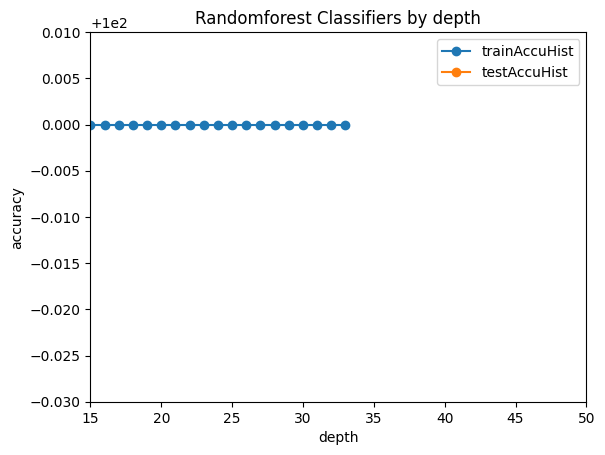

In [20]:
# takes about 60 minutes for range(1,35)
def random_forest_graphs_by_depth():
    trainAccuHist = []
    testAccuHist = []
    for depth in range(1, 35, 1):
        flower_tree, train_accu, test_accu = compute_randomforest_classifier(
            n_estimators=50, max_depth=depth)
        trainAccuHist = np.append(trainAccuHist, train_accu)
        testAccuHist = np.append(testAccuHist, test_accu)
    print(df.shape)
    print(trainAccuHist)

    _len = len(trainAccuHist)
    a = np.arange(_len)
    plt.plot(a, trainAccuHist,
             label="trainAccuHist", marker='o')
    plt.plot(a, testAccuHist,
             label="testAccuHist", marker='o')
    plt.legend()
    plt.title("Randomforest Classifiers by depth")
    plt.xlabel("depth")
    plt.ylabel("accuracy")
    plt.xlim(15, 50)
    plt.ylim(99.97, 100.01)
    plt.show()
random_forest_graphs_by_depth()

train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy: 100.0 %
test accuracy: 0.0 %
(100.0, 0.0) (RandomForestClassifier(max_depth=100, n_estimators=20, random_state=56), 100.0, 0.0) (DecisionTreeClassifier(max_depth=100, random_state=23), 100.0, 0.0)


C:\Users\T470\AppData\Local\Temp\ipykernel_10644\683980033.py:25: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(_min-0.1*diff, _max+0.1*diff)


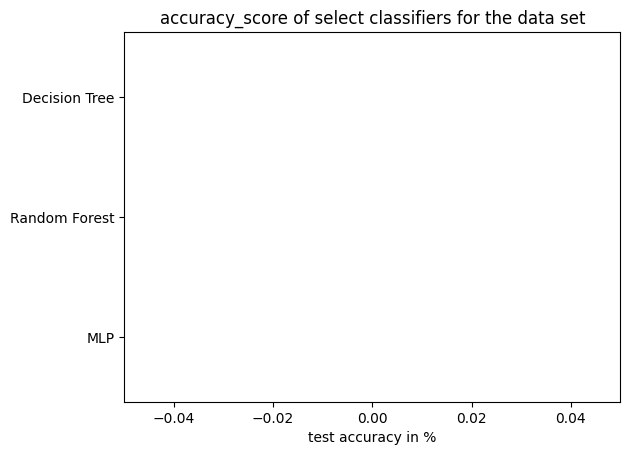

In [21]:
def accuracy_score_whole_dataset_select_classifiers():
    models = ["MLP", "Random Forest", "Decision Tree"]  # , "compute_nearest_neighbors"]
    # mlp mit max_iter 2000
    # randomforest mit max_depth=100 (geht aber wohl eh nur bis ca.30) und n_estimators=20
    # DecisionTree mit max_depth=100
    return1 = compute_mlp(max_iter=2000)
    return2 = compute_randomforest_classifier(n_estimators=20, max_depth=100)
    return3 = compute_decisiontree_classifier(max_depth=100, export_decisiontree_graph=False)
    # thing4 = compute_nearest_neighbors() # takes > 60 minutes I think
    print(return1, return2, return3)
    x = np.arange(len(models))  # the label locations
    results = [return1, return2, return3]
    trainaccs, testaccs = [], []
    for result in results:
        trainaccs.append(result[-2])
        testaccs.append(result[-1])

    testaccs_list = []
    testaccs_list.append(testaccs)
    for thing in testaccs_list:
        plt.barh(x, thing)
        _max = max(thing)
        _min = min(thing)
        diff = _max-_min
        plt.xlim(_min-0.1*diff, _max+0.1*diff)

        plt.title("accuracy_score of select classifiers for the data set")
        plt.xlabel('test accuracy in %')
        plt.yticks(x, models)
        # plt.legend(loc='upper left', ncols=3)
        plt.show()
accuracy_score_whole_dataset_select_classifiers() # 5 minutes

In [23]:
# # Reducing the sample size for slow algorithms
# amount_of_rows = 42
# print("reducing data size to", amount_of_rows, "for slow algorithms")
# df = df.sample(n=amount_of_rows, random_state=42)
# x_ges = df.iloc[:, 0:-1].to_numpy()
# # the lab inverse transform is just incase the new sample will have fever lables than before.
# # Because we only have 2 lables in the creditcard dataset anyway this code achieves nothing.
# # But because we might reuse this notebook we let it in (and it takes 0.0 seconds anyway so might as well)
# df.iloc[:, -1] = lab.inverse_transform(df.iloc[:, -1])
# y_ges = df.iloc[:, -1].to_numpy()
# lab2 = preprocessing.LabelEncoder()
# y_labeled = lab2.fit_transform(y_ges)
# df.iloc[:, -1] = lab.fit_transform(df.iloc[:, -1])
# x_train, x_test, y_train, y_test = train_test_split(
#     x_ges, y_labeled, test_size=0.2, random_state=0)

In [24]:
trainaccs_dict = {}
testaccs_dict = {}
kernels = []
functions = [compute_randomforest_classifier, compute_decisiontree_classifier,
             compute_decisiontree_classifier, compute_naive_bayes, compute_svm, compute_nearest_neighbors,
             compute_nearest_centroid, compute_perceptron, compute_mlp, compute_KNeighbors_classifier]

# alle Classifier auf den kleinen Daten aufrufen und die Accuracies speichern


def call_functions():
    for function in functions:
        print(function.__name__)
        start = time.time()
        if function == compute_svm:
            kernels, trainaccs_svm, testaccs_svm = compute_svm()
            for i in range(len(kernels)):
                print("kernel=", kernels[i], "\ntrainacc=",
                      trainaccs_svm[i], "testacc=", testaccs_svm[i])
                trainaccs_dict[function.__name__+" "+kernels[i]] = trainaccs_svm[i]
                testaccs_dict[function.__name__+" "+kernels[i]] = testaccs_svm[i], ((time.time()-start)/4)
        else:
            returned_tuple = function()
            trainaccs_dict[function.__name__] = returned_tuple[-2]
            testaccs_dict[function.__name__] = returned_tuple[-1], time.time()-start
            print(time.time()-start)
    return trainaccs_dict, testaccs_dict


call_functions()  # 22 minutes for 100.000 rows

compute_randomforest_classifier
train accuracy: 100.0 %
test accuracy: 0.0 %
0.37781310081481934
compute_decisiontree_classifier
train accuracy: 97.05882352941177 %
test accuracy: 0.0 %
0.004995107650756836
compute_decisiontree_classifier
train accuracy: 97.05882352941177 %
test accuracy: 0.0 %
0.008019208908081055
compute_naive_bayes
0.015984296798706055
compute_svm
kernel= linear 
trainacc= 100.0 testacc= 0.0
kernel= poly 
trainacc= 100.0 testacc= 0.0
kernel= rbf 
trainacc= 100.0 testacc= 0.0
kernel= sigmoid 
trainacc= 100.0 testacc= 0.0
compute_nearest_neighbors
0.008132219314575195
compute_nearest_centroid
x_test.shape= (9, 120)
1.0
train accuracy: 100.0 %
test accuracy: 0.0 %
train accuracy2: 1.0 %
0.5388903617858887
compute_perceptron
x_test.shape= (9, 120)
0.04248547554016113
compute_mlp
0.2618899345397949
compute_KNeighbors_classifier
0.01212620735168457


({'compute_randomforest_classifier': 100.0,
  'compute_decisiontree_classifier': 97.05882352941177,
  'compute_naive_bayes': 100.0,
  'compute_svm linear': 100.0,
  'compute_svm poly': 100.0,
  'compute_svm rbf': 100.0,
  'compute_svm sigmoid': 100.0,
  'compute_nearest_neighbors': 100.0,
  'compute_nearest_centroid': 100.0,
  'compute_perceptron': 61.76470588235294,
  'compute_mlp': 100.0,
  'compute_KNeighbors_classifier': 100.0},
 {'compute_randomforest_classifier': (0.0, 0.37781310081481934),
  'compute_decisiontree_classifier': (0.0, 0.008019208908081055),
  'compute_naive_bayes': (0.0, 0.015984296798706055),
  'compute_svm linear': (0.0, 0.011500179767608643),
  'compute_svm poly': (0.0, 0.011500179767608643),
  'compute_svm rbf': (0.0, 0.011500179767608643),
  'compute_svm sigmoid': (0.0, 0.011500179767608643),
  'compute_nearest_neighbors': (0.0, 0.008132219314575195),
  'compute_nearest_centroid': (0.0, 0.5388903617858887),
  'compute_perceptron': (0.0, 0.04248547554016113),
 

computing accuracy scores for candidate classifiers

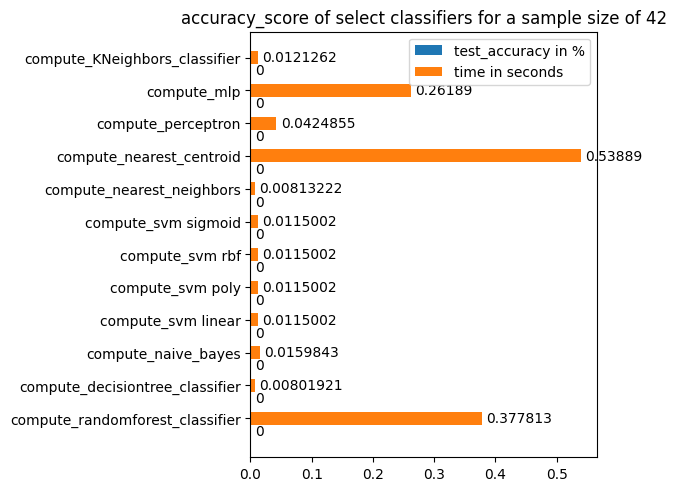

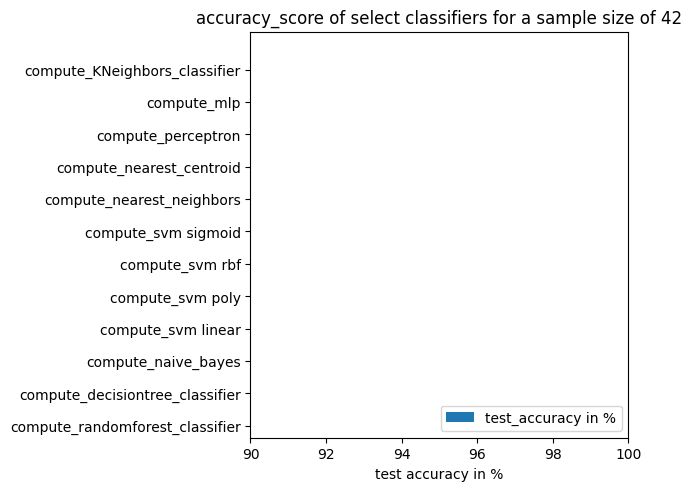

In [25]:
from matplotlib.axes import Axes
TIME_IN_SECONDS_STRING = "time in seconds"
# sorting the testaccs by value... there has to be a better way...
sorted_list = sorted(testaccs_dict.items(), key=lambda x: x[1][0])
testacc_dict_sorted = {}
values0 = []
values1 = []
names = []
for key, values in sorted_list:
    names.append(key)
    values0.append(values[0])
    values1.append(values[1])
values0_tuple = tuple(values0)
testacc_dict_sorted = {"test_accuracy in %": tuple(values0), TIME_IN_SECONDS_STRING: tuple(values1)}

# GROUPED PLOTS from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
# Plot 1
x = np.arange(len(testaccs_dict))  # the label locations
height = 0.4  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')
ax: Axes = ax  # this line is necessary for code recommendations (seeing what methods the class has)..
for attribute, measurement in testacc_dict_sorted.items():
    offset = height * multiplier
    barContainers = ax.barh(x + offset, measurement, height, label=attribute)
    ax.bar_label(barContainers, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# plt.title("accuracy_score of select classifiers for a sample size of "+str(amount_of_rows))
ax.set_title("accuracy_score of select classifiers for a sample size of "+str(amount_of_rows))
ax.set_yticks(x + height, names)
ax.legend(loc='upper right', ncols=1)
plt.show()

# Plot 2 with zoom in
fig, ax = plt.subplots(layout='constrained')
ax: Axes = ax  # this line is necessary for code recommendations (seeing what methods the class has)..
for attribute, measurement in testacc_dict_sorted.items():
    if (attribute == TIME_IN_SECONDS_STRING):
        continue
    offset = height * multiplier
    barContainers = ax.barh(x + offset, measurement, height, label=attribute)
    ax.bar_label(barContainers, padding=3)
    multiplier += 1
# Add some text for labels, title and custom x-axis tick labels, etc.
# plt.title("accuracy_score of select classifiers for a sample size of "+str(amount_of_rows))
ax.set_title("accuracy_score of select classifiers for a sample size of "+str(amount_of_rows))
ax.set_xlabel('test accuracy in %')
ax.set_yticks(x + height, names)
# plt.legend(loc='upper left', ncols=3)
ax.legend(loc='lower right', ncols=1, labels=["test_accuracy in %"])
ax.set_xlim(90, 100)
plt.show()

train accuracy: 97.05882352941177 %
test accuracy: 0.0 %
classification_report train:
               precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000         1
         1.0     1.0000    1.0000    1.0000         1
         2.0     1.0000    1.0000    1.0000         1
         3.0     1.0000    1.0000    1.0000         1
         4.0     1.0000    1.0000    1.0000         1
         5.0     1.0000    1.0000    1.0000         1
         8.0     1.0000    1.0000    1.0000         1
         9.0     1.0000    1.0000    1.0000         1
        10.0     1.0000    1.0000    1.0000         1
        11.0     1.0000    1.0000    1.0000         1
        12.0     1.0000    1.0000    1.0000         1
        13.0     1.0000    1.0000    1.0000         1
        15.0     1.0000    1.0000    1.0000         1
        17.0     1.0000    1.0000    1.0000         1
        18.0     1.0000    1.0000    1.0000         1
        19.0     1.0000    1.0000    1.0000     

c:\Users\T470\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\T470\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\T470\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

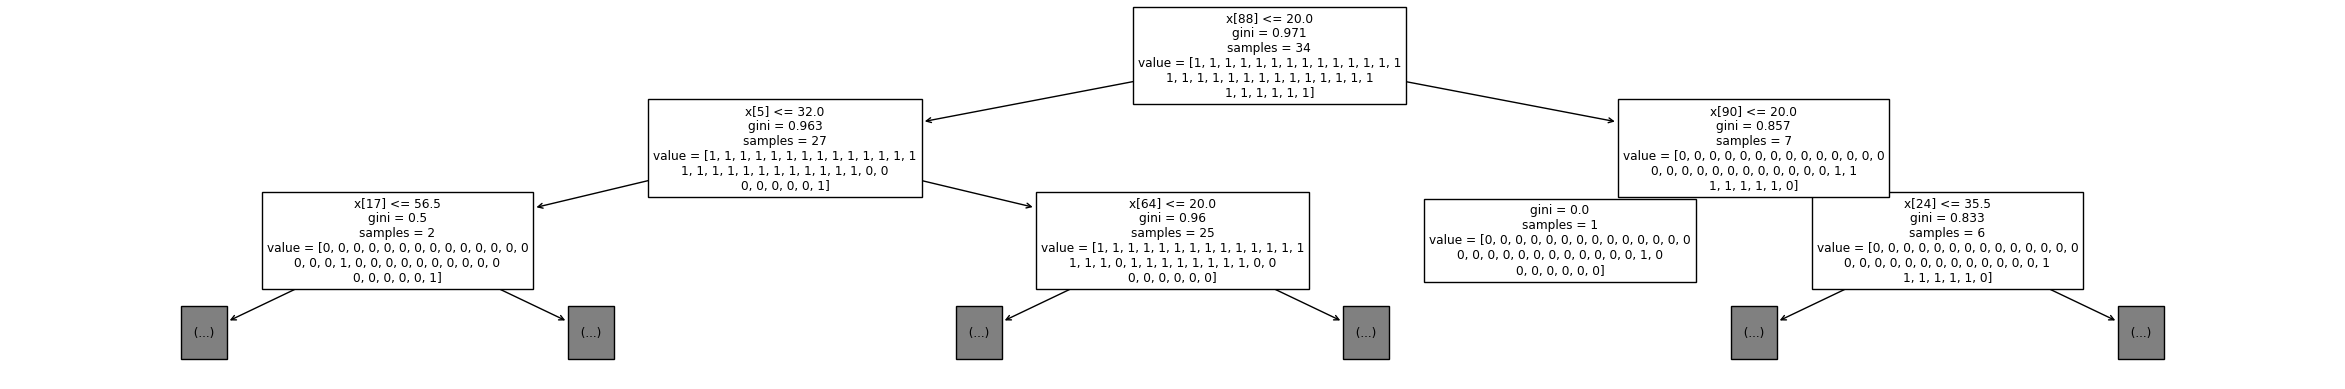

In [26]:
# classification report
mytree, trainaccs_svm, testaccs_svm = compute_decisiontree_classifier_tree_and_cm(df, max_depth=10)

fig, ax = plt.subplots()
fig.set_figwidth(30)
tree.plot_tree(mytree, max_depth=2)
plt.show()